## Régression linéaire et prédictions ##

Ce notebook a pour but de modéliser et d'entraîner une régression linéaire sur le dataset 'datas' et, ensuite, de faire des prédictions d'anomalies de températures jusqu'en 2060.

Import des librairies

In [1]:
# import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
   

In [2]:
from google.colab import drive
drive.mount('/gdrive')

import os
path = "/gdrive/.shortcut-targets-by-id/1n7Bl5_QVpPlRHXYKfEZjaJsttl5Af03A/Projet temperatures/datasets/"
os.listdir(path)

Mounted at /gdrive


['co2_data.csv',
 'global_temperature.csv',
 'climate-change_owid.csv',
 'temperature-anomaly.csv',
 'hadcrut-surface-temperature-anomaly.csv',
 'co2_data.gsheet',
 'Global_annual_mean_temp.csv',
 'temperature_by_continent',
 'Continent_temperatures_anomalies_by_year.csv',
 'datas.csv']

Import du dataset et préparation au split

In [25]:
df = pd.read_csv(path +'datas.csv', header = 0)

# Code standard
# df = pd.read_csv('datas.csv', header = 0)

In [26]:
df = df.drop('iso_code', axis = 1)

feats = df.drop('temp_anomaly', axis = 1)

target = df['temp_anomaly']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25, random_state = 42)

Pre-processing et encodage

In [69]:
cat_train = pd.get_dummies(X_train['country'], columns = 'country') 
cat_test = pd.get_dummies(X_test['country'], columns = 'country') 

In [70]:
X_train2 = pd.concat([X_train,cat_train], axis = 1)
X_test2 = pd.concat([X_test,cat_test], axis = 1)

In [71]:
X_train = X_train2.drop('country', axis = 1)
X_test = X_test2.drop('country', axis = 1)

Importation du modèle de régression linéaire

In [73]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("Accuracy score de la Régression Logistique : ",
      regressor.score(X_test, y_test))


Accuracy score de la Régression Logistique :  0.7067733871312096


In [75]:
print('Coefficient de détermination du modèle sur train:', regressor.score(X_train, y_train))
print('Coefficient de détermination du modèle sur test:', regressor.score(X_test, y_test))


Coefficient de détermination du modèle sur train: 0.6907730750775483
Coefficient de détermination du modèle sur test: 0.7067733871312096


Création du dataframe df_regressor_predict

Ce dataframe contiendra, à la place de la valeur cible 'temp_anomaly', la valeur prédite pour le modèle (colonne 'Prediction').

Cela va nous permettre de confronter graphiquement les anomalies de températures réelles et les prédictions du modèle.

In [76]:
df_regressor_predict = df.drop(['temp_anomaly'], axis = 1)

df_regressor_predict = pd.get_dummies(df_regressor_predict, columns=df_regressor_predict.select_dtypes(exclude=['int64','float64']).columns)

if len(df_regressor_predict.columns) == len(X_test.columns):
  print('Longueurs identiques')
else :
  print('Longueurs différentes')

Longueurs identiques


In [77]:
df_regressor_predict = df_regressor_predict.rename(columns={"country_Africa":"Africa","country_Asia":"Asia","country_Europe":"Europe","country_North America":"North America","country_Oceania":"Oceania","country_South America":"South America"})

# Affichage du dataframe pour contrôle

df_regressor_predict.head()

,year,population,gdp,cement_co2,co2,co2_per_capita,coal_co2,flaring_co2,gas_co2,methane,nitrous_oxide,oil_co2,total_ghg,Africa,Asia,Europe,North America,Oceania,South America
0,1910,144170612.0,6.759497e+10,0.0,17.411,0.121,17.411,0.0,0.0,16.37,5.01,0.000,28.79,1,0,0,0,0,0
1,1911,144586985.0,6.759497e+10,0.0,16.865,0.117,16.854,0.0,0.0,16.37,5.01,0.011,28.79,1,0,0,0,0,0
2,1912,145180745.0,6.759497e+10,0.0,17.954,0.124,17.869,0.0,0.0,16.37,5.01,0.084,28.79,1,0,0,0,0,0
3,1913,145775225.0,6.759497e+10,0.0,19.606,0.134,19.566,0.0,0.0,16.37,5.01,0.040,28.79,1,0,0,0,0,0
4,1914,146378430.0,6.759497e+10,0.0,19.551,0.134,19.243,0.0,0.0,16.37,5.01,0.308,28.79,1,0,0,0,0,0


In [78]:
# Création de la colonne 'Prediction'

df_regressor_predict['Prediction'] = regressor.predict(df_regressor_predict)

Graphique comparatif

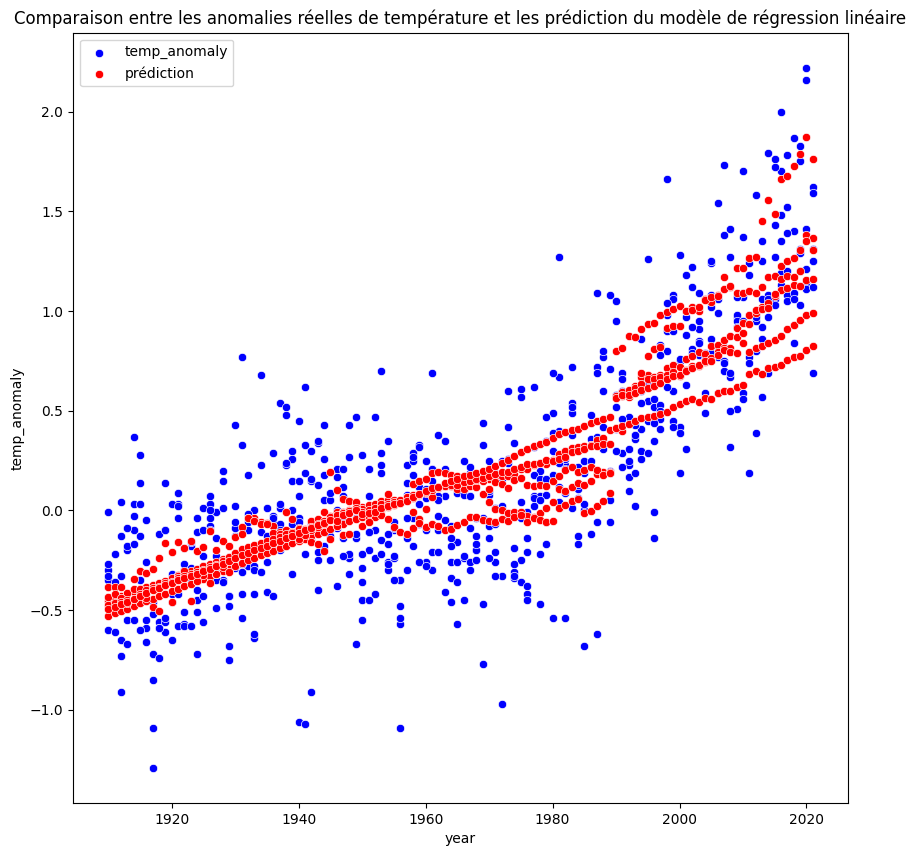

In [101]:
import seaborn as sns

fig = plt.figure(figsize = (10,10))
sns.scatterplot(data=df, x='year',y='temp_anomaly', color = 'blue', label = 'temp_anomaly')
sns.scatterplot(data=df_regressor_predict, x='year',y='Prediction', color = 'red', label = 'prédiction')
plt.title('Comparaison entre les anomalies réelles de température et les prédiction du modèle de régression linéaire')
plt.legend();

On constate un décrochage à la hausse des prédictions, à partir de 1990. Il est probable que certaines variables (méthane, oxyde nitreux) qui n'ont pas de mesures avant cette date, aient une influence ici.

Comparaison des deux droites de régression linéaire

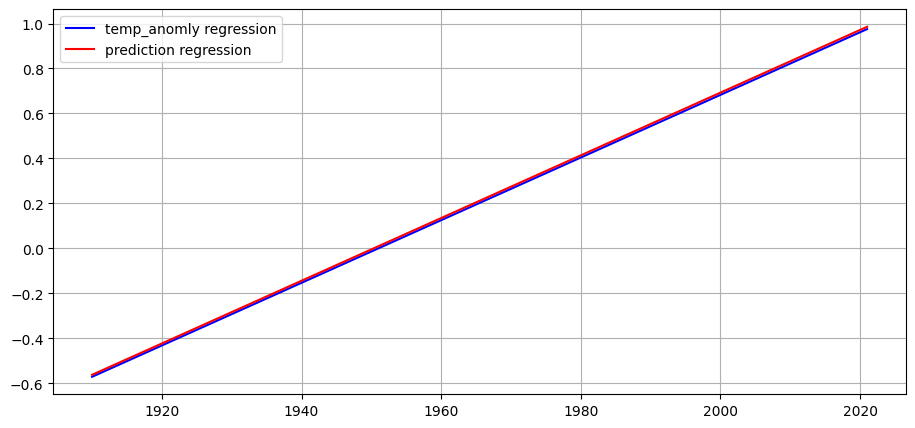

In [103]:
from scipy.stats import linregress

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(df.year, df.temp_anomaly)

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(df_regressor_predict.year, df_regressor_predict.Prediction)

plt.figure(figsize = (11,5))
plt.plot(df.year, intercept1 + slope1 * df.year, color = 'blue', label = 'temp_anomly regression')
plt.plot(df_regressor_predict.year, intercept2 + slope2 * df_regressor_predict.year, color = 'red', label = 'prediction regression')

plt.legend()
plt.grid(True);

Les deux droites sont sensiblement identiques !

Prédictions jusqu'à 2060

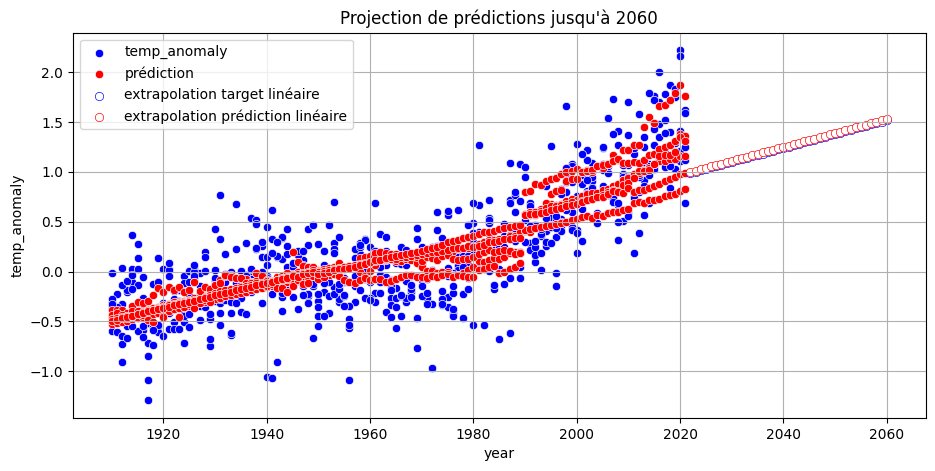

In [104]:
years = np.arange(df.year.max()+1,2061)

extrapolated_y1 = intercept1 + slope1* years
extrapolated_y2 = intercept2 + slope2* years

plt.figure(figsize=(11,5))
sns.scatterplot(data=df, x='year',y='temp_anomaly', color = 'blue', label = 'temp_anomaly')
sns.scatterplot(data=df_regressor_predict, x='year',y='Prediction', color = 'red', label = 'prédiction')

sns.scatterplot(x=years, y=extrapolated_y1, edgecolor = 'blue', facecolor = 'white', label = 'extrapolation target linéaire')
sns.scatterplot(x=years, y=extrapolated_y2, edgecolor = 'red', facecolor = 'white', label = 'extrapolation prédiction linéaire')
plt.title("Projection de prédictions jusqu'à 2060")
plt.legend()
plt.grid(True);

Les prédictions suivent une pente ascendante constante, malgré un léger décrochage du nuage des prédictions à partir de 1990.

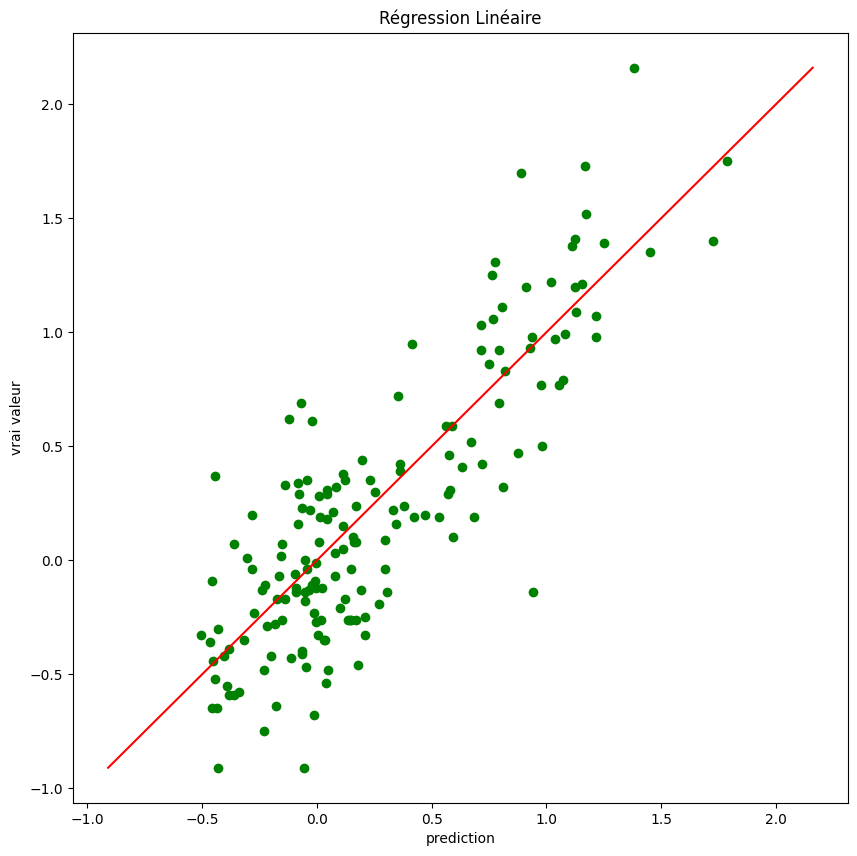

In [86]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
pred_test = regressor.predict(X_test)
plt.scatter(pred_test, y_test, c='green')

plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), color = 'red')
plt.xlabel("prediction")
plt.ylabel("vrai valeur")
plt.title('Régression Linéaire')

plt.show()

In [87]:
from sklearn.metrics import mean_squared_error
print("RMSE :", mean_squared_error(y_test, pred_test, squared = False))

RMSE : 0.32549517604845574


In [88]:
from sklearn.tree import DecisionTreeRegressor 
  
regressor = DecisionTreeRegressor(random_state=42) 
  
regressor.fit(X_train, y_train)

#On observe un réel overfitting
print(regressor.score(X_train,y_train))
print(regressor.score(X_test,y_test))

1.0
0.6464631349406502


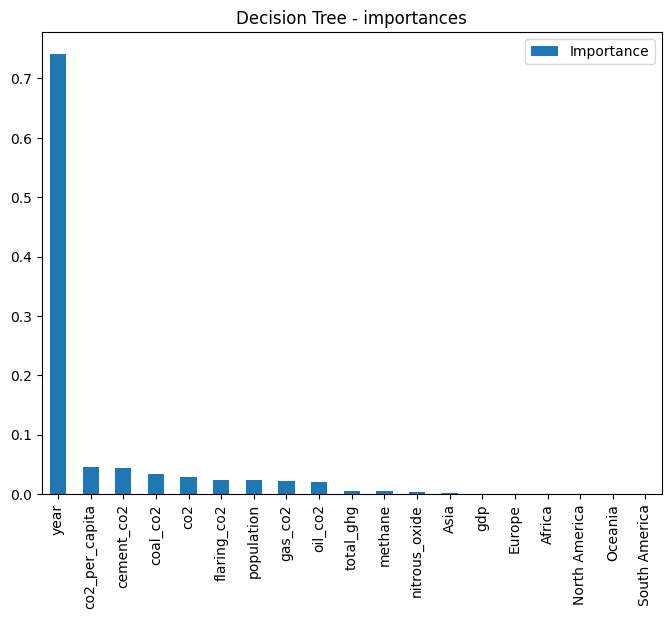

In [89]:
import matplotlib.pyplot as plt

feat_importances = pd.DataFrame(regressor.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))
plt.title('Decision Tree - importances')
plt.show()

In [90]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state = 42)

rfr.fit(X_train, y_train)

print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9538371825715984
0.7465734357517586


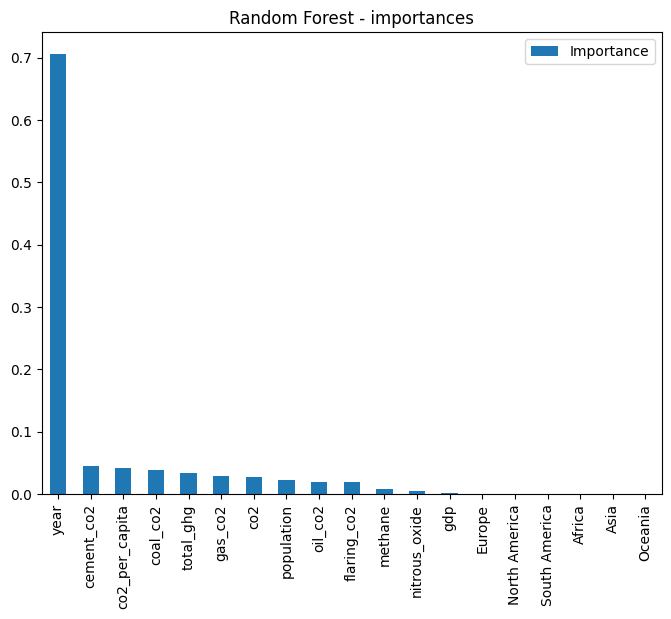

In [91]:
feat_importances = pd.DataFrame(rfr.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))
plt.title('Random Forest - importances')
plt.show()